In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix, roc_curve

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [102]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
X = deepcopy(train_df)

In [3]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])

In [15]:
def data_cleaning(X):
    X[['Section', 'Num', 'Side']] = X['Cabin'].str.split('/', expand=True)
    X['Expenditure'] = X[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
    X.drop(['PassengerId', 'Name', 'Cabin', 'Num', 'RoomService',
            'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], axis=1, inplace=True)
    X[['HomePlanet']] = X[['HomePlanet']].fillna('Mars')
    X[['CryoSleep']] = X[['CryoSleep']].fillna(True)
    X[['Destination']] = X[['Destination']].fillna('PSO J318.5-22')
    X[['VIP']] = X[['VIP']].fillna(True)
    X[['Section']] = X[['Section']].fillna('T')
    X[['Side']] = X[['Side']].fillna('P')
    X[['Age']] = X[['Age']].fillna(28)

    X.drop('VIP', axis=1, inplace=True)
    
    return X

In [27]:
X = data_cleaning(X)

In [28]:
encodable_columns = ['HomePlanet', 'CryoSleep', 'Destination', 'Section', 'Side']
scalable_columns = ['Age', 'Expenditure']
col_trans = ColumnTransformer([
    ('encoder', OrdinalEncoder(), encodable_columns),
    ('scaler', MinMaxScaler(feature_range=(0, 10)), scalable_columns)])

X_transformed = pd.DataFrame(col_trans.fit_transform(X))
X_transformed.columns = encodable_columns + scalable_columns
X_transformed.head()


,HomePlanet,CryoSleep,Destination,Section,Side,Age,Expenditure
0,1.0,0.0,2.0,1.0,0.0,4.936709,0.000000
1,0.0,0.0,2.0,5.0,1.0,3.037975,0.204518
2,1.0,0.0,2.0,0.0,1.0,7.341772,2.885209
3,1.0,0.0,2.0,0.0,1.0,4.177215,1.438297
4,0.0,0.0,2.0,5.0,1.0,2.025316,0.303165


In [6]:
y = X_transformed['Transported']
X_transformed.drop('Transported', axis=1, inplace=True)

In [29]:
X.head()

,HomePlanet,CryoSleep,Destination,Age,Transported,Section,Side,Expenditure
0,Europa,False,TRAPPIST-1e,39.0,False,B,P,0.0
1,Earth,False,TRAPPIST-1e,24.0,True,F,S,736.0
2,Europa,False,TRAPPIST-1e,58.0,False,A,S,10383.0
3,Europa,False,TRAPPIST-1e,33.0,False,A,S,5176.0
4,Earth,False,TRAPPIST-1e,16.0,True,F,S,1091.0


In [8]:
print(X['Age'].describe())
X_transformed['Age'].describe()

count    8693.000000
mean       28.810882
std        14.339536
min         0.000000
25%        20.000000
50%        27.000000
75%        37.000000
max        79.000000
Name: Age, dtype: float64


count    8693.000000
mean        3.646947
std         1.815131
min         0.000000
25%         2.531646
50%         3.417722
75%         4.683544
max        10.000000
Name: Age, dtype: float64

In [30]:
corr_matrix = X_transformed.corr()
corr_matrix['Transported'].sort_values(ascending=True)

KeyError: 'Transported'

In [35]:
#Logistic Regression - [0.70902818, 0.72742956, 0.70845313, 0.71979287, 0.72842348]
#SGDClassifier - [0.70615296, 0.71822887, 0.71075331, 0.73187572, 0.72957422]
#DecisionTreeClassifier(criterion='entropy', max_depth=5) [0.7280046 , 0.73375503, 0.72110408, 0.75258918, 0.74913694]
classifier = DecisionTreeClassifier(criterion='entropy', max_depth=5)
classifier.fit(X_transformed, y)
cross_val_score(classifier, X_transformed, y)

array([0.72512938, 0.74468085, 0.74008051, 0.76237054, 0.75028769])

[]

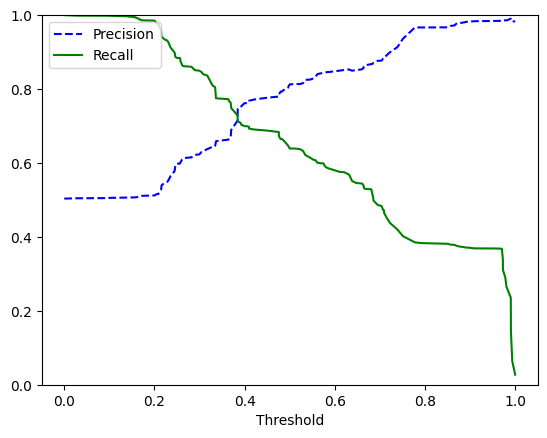

In [32]:
predictions = cross_val_predict(classifier, X_transformed, y, method='predict_proba')
preds = predictions[:, 1] > 0.4
precisions, recalls, thresholds = precision_recall_curve(y, predictions[:, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot()

In [12]:
predictions = cross_val_predict(classifier, X_transformed, y)
confusion_matrix(y, predictions)

array([[3674,  641],
       [1580, 2798]])

In [13]:
print(confusion_matrix(y, preds))

[[3362  953]
 [1317 3061]]


[]

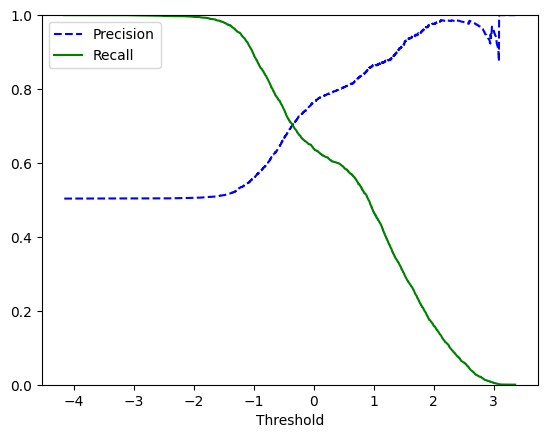

In [187]:
scores = cross_val_predict(classifier, X_transformed, y, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y, scores)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot()

In [206]:
parameters = {'criterion': ('gini', 'entropy', 'log_loss'),
             'max_depth': range(1,10),
             'min_samples_split': range(2, 6)}
grid_search = GridSearchCV(classifier, parameters)
grid_search.fit(X_transformed, y)

GridSearchCV(estimator=DecisionTreeClassifier(max_depth=1),
             param_grid={'criterion': ('gini', 'entropy', 'log_loss'),
                         'max_depth': range(1, 10),
                         'min_samples_split': range(2, 6)})

In [207]:
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}

In [14]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [103]:
submission = pd.DataFrame()
submission['PassengerId'] = test_df['PassengerId']
X_test = data_cleaning(test_df)
print(X_test.head())

X_test_transformed = pd.DataFrame(col_trans.transform(X_test))
X_test_transformed.columns = encodable_columns + scalable_columns
X_test_transformed.head()

  HomePlanet  CryoSleep  Destination   Age Section Side  Expenditure
0      Earth       True  TRAPPIST-1e  27.0       G    S          0.0
1      Earth      False  TRAPPIST-1e  19.0       F    S       2832.0
2     Europa       True  55 Cancri e  31.0       C    S          0.0
3     Europa      False  TRAPPIST-1e  38.0       C    S       7418.0
4      Earth      False  TRAPPIST-1e  20.0       F    S        645.0


,HomePlanet,CryoSleep,Destination,Section,Side,Age,Expenditure
0,0.0,1.0,2.0,6.0,1.0,3.417722,0.000000
1,0.0,0.0,2.0,5.0,1.0,2.405063,0.786951
2,1.0,1.0,0.0,2.0,1.0,3.924051,0.000000
3,1.0,0.0,2.0,2.0,1.0,4.810127,2.061300
4,0.0,0.0,2.0,5.0,1.0,2.531646,0.179231


In [104]:
predictions = pd.DataFrame(classifier.predict(X_test_transformed))

In [105]:
print(submission.shape)
predictions.shape

(4277, 1)


(4277, 1)

In [106]:
submission = pd.concat([submission, predictions.astype(bool)], axis=1)

In [107]:
submission.columns = ['PassengerId', 'Transported']

In [108]:
submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,False
4,0023_01,False


In [109]:
submission.to_csv('submission.csv', index=False)